In [9]:
from data_provider import DataModel
dm = DataModel()
dm.read_from_csvs("../../xcels", ["master0.csv", "master1.csv"])

In [467]:
df = dm.get(dm.TA_SYMBOLS[0], "1397-01-01" , "1398-01-01")

In [172]:
df.columns

Index(['symbol', 'name', 'amount', 'volume', 'value', 'lastday', 'open',
       'close', 'last-change', 'last-percent', 'ending', 'ending-change',
       'ending-percent', 'min', 'max', 'year', 'month', 'day', 'diff_min_max',
       'diff_open', 'adj_min', 'adj_max', 'adj_close', 'adj_open',
       'adj_ending', 'log_adj_open', 'log_adj_close', 'log_adj_ending',
       'log_adj_min', 'log_adj_max', 'adj_scale'],
      dtype='object')

In [35]:
# %%writefile ta_module.py


import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
from math import pi
import math
import matplotlib.pyplot as plt

accepted_error = 0.03

#########################################################################
#########################################################################
#########################################################################
#########################################################################


def find_supports(df, minimum_touch = 3):
    stocko = df["log_adj_open"].tolist()
    stockc = df["log_adj_close"].tolist()
    dates = df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array
    
    lows = []
    lows_price = []
    for j in range(len(stocko)): 
#         minimum = min(stocko[j], stockc[j])
        if ( (j >10) and (j+10 < len(stocko)) ):
            if (stockc[j]<= min(stockc[j-10:j+10])):
#             if (minimum<= min(stocko[j-10:j+10]) and minimum<= min(stockc[j-10:j+10])):
                lows.append(j)
                lows_price.append(stockc[j])

        #finding the best lines 
    # cnt = numbers of line segments
    cnt = 0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    startm = []
    stopm = []
    checkedpoint = []
    lastpoint = 0
    count_max = 0
    a_maxm = []
    b_maxm = []
    xarr = lows
    yarr = lows_price
    max_last = 0
    # all tangents from 0.04 to -0.04 digree . i will break them in to 1000 pieces this is too short because we're using log numbers
    digree = np.linspace(-0.05, 0.05, 1000)
    coefs = np.tan(digree * pi / 180)


    for point in range(len(xarr)) :
        max_last = 0  
        count_max = 0
    #  x and y are the ones of this point
        x = xarr[point]
        y = yarr[point]
    # for this point i am breaking the line into 100 pieces
#         b_fakes = np.linspace(y-(y * accepted_error), y+(y * accepted_error), 100)
        b_fakes = np.linspace(math.log10((10 ** y)-((10 ** y) * accepted_error)), math.log10((10 ** y)+((10 ** y) * accepted_error)), 100)
        for b in b_fakes:
            for a in coefs:
                count = 0
                for p in range(point+1, len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if(x_ * a+b >= math.log10((10 ** y_)-((10 ** y_) * accepted_error))) and (x_ * a+b<= math.log10((10 ** y_)+((10 ** y_) * accepted_error))):
#                     if((x_ * a+b >= y_-(y_ * accepted_error)) and (x_ * a+b<= y_+(y_ * accepted_error))):
                        count+= 1
                        lastpoint = xarr[p]
                    elif (math.log10((10 ** y_)+((10 ** y_) * accepted_error)) < x_ * a+b ): 
#                     elif (y_+(y_ * accepted_error) < x_ * a+b ):
                        break
                
                if(count >count_max):
                    max_last = lastpoint # max last baraye save kardane lastpointi ke niaz darime . maxof_a , b ham hamintor
                    count_max = count
                    maxof_a = a
                    maxof_b = b
                lastpoint = 0

    #   if this start point include a line that touch three points: count_max are the number of other points ( = 2) . so it should be >= minimum touch -1
        if(count_max >= minimum_touch-1):
            repetitious = False
            a_in_radian = math.atan(maxof_a)
            a_in_degree = math.degrees(a_in_radian)
            for cnt in range(len(a_maxm)):
                if((math.degrees(math.atan(a_maxm[cnt])) >= a_in_degree -0.004) and 
                   (math.degrees(math.atan(a_maxm[cnt])) <= a_in_degree +0.004) and
                   (stopm[cnt] == max_last)):
                    repetitious = True

            if(not(repetitious)):
                a_maxm.append(maxof_a)
                b_maxm.append(maxof_a * (-x)+maxof_b)
                startm.append(x)
                stopm.append(max_last)
    
#     dates[startm]  because we wanna return exact date
    return startm, stopm, a_maxm, b_maxm, lows


#########################################################################
#########################################################################
#########################################################################
#########################################################################

def find_resistances(df, minimum_touch = 3):
    stocko = df["adj_open"].tolist()
    stockc = df["adj_close"].tolist()
    dates = df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array
    

    highs = []
    highs_price = []
    for j in range(len(stocko)): 
        maximum = max(stocko[j], stockc[j])
        if ( (j >10) and (j+10 < len(stocko)) ):
            if (maximum >= max(stocko[j-10:j+10]) and maximum >= max(stockc[j-10:j+10])):
                highs.append(j)
                highs_price.append(maximum)

    #finding the best lines 
    # cnt = numbers of line segments
    cnt = 0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    start = []
    stop = []
    checkedpoint = []
    lastpoint = 0
    count_max = 0
    a_max = []
    b_max = []
    xarr = highs
    yarr = highs_price
    max_last = 0
    # all tangents from 80 to -80 digree . i will break them in to 1000 pieces
    digree = np.linspace(-80, 80, 1000)
    digrees = np.tan(digree * pi / 180)


    for point in range(len(xarr)) :
        max_last = 0
        count_max = 0
    #  x and y are the ones of this point
        x = xarr[point]
        y = yarr[point]
    # for this point i am breaking the line into 100 pieces
        b_fakes = np.linspace(y-15, y+15, 100)  
        for b in b_fakes:
            for a in digrees:
                count = 0
                for p in range(point+1, len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if((x_ * a+b >= y_-15) and (x_ * a+b<= y_+15)):
                        count+= 1
                        lastpoint = xarr[p]
                    elif (y_-15 > x_ * a+b ):
                        break
                if(count >count_max):
                    max_last = lastpoint # max last baraye save kardane lastpointi ke niaz darime . maxof_a , b ham hamintor
                    count_max = count
                    maxof_a = a
                    maxof_b = b
                lastpoint = 0

    #   if this start point include a line that touch three points: count_max are the number of other points .
        if(count_max >= minimum_touch-1):
            repetitious = False
            a_in_radian = math.atan(maxof_a)
            a_in_degree = math.degrees(a_in_radian)
            for cnt in range(len(a_max)):
                if((math.degrees(math.atan(a_max[cnt])) >= a_in_degree -5) and 
                   (math.degrees(math.atan(a_max[cnt])) <= a_in_degree +5) and
                   (stop[cnt] == max_last)):
                    repetitious = True

            if(not(repetitious)):
                a_max.append(maxof_a)
                b_max.append(maxof_a * (-x)+maxof_b)
                start.append(x)
                stop.append(max_last)
    #     dates[startm]  because we wanna return exact date
#     start_dates = df.iloc[start].index
    return start, stop, a_max, b_max

In [449]:
#  this is with mse 
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime
from math import pi
import math
import matplotlib.pyplot as plt

accepted_error=0.03


def find_optimum_points(data : list, ismax : bool = True):
    last = -1000
    x, y = [], []
    if ismax:
        for j in range(len(data)): 
            if (j > 3) and (j + 3 < len(data)):
                if (data[j] >= max(data[j - 3: j + 3]) and last < j - 3):
                    last = j
                    x.append(j)
                    y.append(data[j])
    if not(ismax):
        for j in range(len(data)): 
            if (j > 3) and (j + 3 < len(data)):
                if (data[j]<=min(data[j - 3: j + 3]) and last < j - 3):
                    last = j
                    x.append(j)
                    y.append(data[j])
    return x, y




#########################################################################
#########################################################################
#########################################################################
#########################################################################


def find_supports(df,minimum_touch=3):
    
#     lines_df=pd.DataFrame(columns=["a","b","start","stop","mse","touch", "mse/touch"])
    lines_array=[]
    stockc=df["log_adj_close"].tolist()
    dates=df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array

    lows, lows_price = find_optimum_points(df["log_adj_close"], ismax = False)

        #finding the best lines 
    # cnt = numbers of line segments
    cnt=0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    startm=[]
    stopm=[]
    checkedpoint=[]
    lastpoint=0
    count_max=0
    a_maxm=[]
    b_maxm=[]
    xarr, yarr = find_optimum_points(df, ismax = False)
    max_last=0
    # all tangents from 0.04 to -0.04 digree . i will break them in to 1000 pieces this is too short because we're using log numbers
    digree=np.linspace(-0.12,0.12,1000)
    coefs=np.tan(digree*pi / 180)


    for point in range(len(xarr)) :
#         bestline=pd.DataFrame([],columns=["a","b","start","stop","mse","touch", "mse/touch"])
        bestline=[]
        max_last=0  
        count_max=0
    #  x and y are the ones of this point
        x=xarr[point]
        y=yarr[point]
    # for this point i am breaking the line into 100 pieces
#         b_fakes=np.linspace(y-(y*accepted_error),y+(y*accepted_error),100)
        b_fakes=np.linspace(math.log10((10**y)-((10**y)*accepted_error)),math.log10((10**y)+((10**y)*accepted_error)),100)
        for b in b_fakes:
            for a in coefs:
                points_in_touch = []
                count = 0
                lastpoint=0
                for p in range(point+1,len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if(x_*a+b>=math.log10((10**y_)-((10**y_)*accepted_error))) and (x_*a+b<=math.log10((10**y_)+((10**y_)*accepted_error))):
#                     if((x_*a+b>=y_-(y_*accepted_error)) and (x_*a+b<=y_+(y_*accepted_error))):
                        points_in_touch.append(xarr[p])
                        count+=1
                        lastpoint=xarr[p]
                    elif (math.log10((10**y_)+((10**y_)*accepted_error)) < x_*a+b ): 
#                     elif (y_+(y_*accepted_error) < x_*a+b ):
                        break
                
                if(count >= minimum_touch-1):
                    cnt_time[0] += 1
                    
                    mse = mean_squared_error([stockc[x]] +[stockc[indice] for indice in points_in_touch], [b] + [a*(xx-x) + b for xx in points_in_touch])
# THIS IS THE STRUCTURE OF bestline ARRAY AND EACH ROW OF lines_array : [0:COEF, 1:INTERCEPT, 2:START_POINT_X, 3:STOP_POINT_X, 4:MSE, 5:NUMBER OF TOUCHS, 6:MSE/NUMBER OF TOUCH]

                    lines_array.append([a, a*(-x)+b,x,lastpoint, mse,count + 1, mse / (count + 1)])
                
        if len(lines_array) > 0 :
            linee=np.array(lines_array)
#             CONVERT lines_array TYPE TO NP.ARRAY AIMING TO ITERATE EASILY AND WORK AS A MATRIX 
            min_mt = min(linee[:,6])
    
            for cntt in lines_array:
                if cntt[6] == min_mt:
                    bestline = cntt
                    break
            lines_array = []

    #   if this start poin]t include a line that touch three points: count_max are the number of other points (=2) . so it should be >= minimum touch -1
#       mse of the line should not be more than a specific number 
            if(bestline[5] >= minimum_touch-1) and (bestline[4] < 3e-5 ):
                repetitious = False
                a_in_radian = math.atan(bestline[0])
                a_in_degree = math.degrees(a_in_radian)
                for cnt in range(len(a_maxm)):
                    if((math.degrees(math.atan(a_maxm[cnt])) >= a_in_degree - 0.004) and 
                       (math.degrees(math.atan(a_maxm[cnt])) <= a_in_degree + 0.004) and
                       (stopm[cnt]==bestline[3])):
                        repetitious=True

                if(not(repetitious)):
                    a_maxm.append(bestline[0])
                    b_maxm.append(bestline[1])
                    startm.append(bestline[2])
                    stopm.append(bestline[3])

#     dates[startm]  because we wanna return exact date

    return startm,stopm,a_maxm,b_maxm,lines_df,lows


#########################################################################
#########################################################################
#########################################################################
#########################################################################
from tqdm import tqdm
def find_resistances(df,minimum_touch=3):
    final_lines = pd.DataFrame([],columns=["first_point", "last_point", "coefs", "intercepts"])
#     lines_df=pd.DataFrame(columns=["a","b","start","stop","mse","touch", "mse/touch"])
    lines_array=[]
    stockc=df["log_adj_close"].tolist()
    dates=df.index # for converting startm s to real date .... startm and stopm s are some indexes of stoko array

    lows, lows_price = find_optimum_points(df["log_adj_close"])

        #finding the best lines 
    # cnt = numbers of line segments
    cnt=0
    # start and stop[cnt] = start poit in x axes and stop point for each line segments
    startm=[]
    stopm=[]
    checkedpoint=[]
    lastpoint=0
    count_max=0
    a_maxm=[]
    b_maxm=[]
    xarr=lows
    yarr=lows_price
    max_last=0
    # all tangents from 0.04 to -0.04 digree . i will break them in to 1000 pieces this is too short because we're using log numbers
    digree=np.linspace(-0.12,0.12,1000)
    coefs=np.tan(digree*pi / 180)


    for point in tqdm(range(len(xarr))) :
#         bestline=pd.DataFrame([],columns=["a","b","start","stop","mse","touch", "mse/touch"])
        bestline=[]
        max_last=0  
        count_max=0
    #  x and y are the ones of this point
        x=xarr[point]
        y=yarr[point]
    # for this point i am breaking the line into 100 pieces
#         b_fakes=np.linspace(y-(y*accepted_error),y+(y*accepted_error),100)
        b_fakes=np.linspace(math.log10((10**y)-((10**y)*accepted_error)),math.log10((10**y)+((10**y)*accepted_error)),100)
        for b in b_fakes:
            for a in coefs:
                points_in_touch = []
                count = 0
                lastpoint=0
                for p in range(point+1,len(xarr)):
                #  x_ and y_ s are for all next points in new dimensions !!
                    x_ = xarr[p]-x
                    y_ = yarr[p]
                    if(x_*a+b>=math.log10((10**y_)-((10**y_)*accepted_error))) and (x_*a+b<=math.log10((10**y_)+((10**y_)*accepted_error))):
#                     if((x_*a+b>=y_-(y_*accepted_error)) and (x_*a+b<=y_+(y_*accepted_error))):
                        points_in_touch.append(xarr[p])
                        count+=1
                        lastpoint=xarr[p]
                    elif (math.log10((10**y_)+((10**y_)*accepted_error)) > x_*a+b ): 
#                     elif (y_+(y_*accepted_error) < x_*a+b ):
                        break
                
                if(count >= minimum_touch-1):
                    cnt_time[0] += 1
                    
                    mse = mean_squared_error([stockc[x]] +[stockc[indice] for indice in points_in_touch], [b] + [a*(xx-x) + b for xx in points_in_touch])
# THIS IS THE STRUCTURE OF bestline ARRAY AND EACH ROW OF lines_array : [0:COEF, 1:INTERCEPT, 2:START_POINT_X, 3:STOP_POINT_X, 4:MSE, 5:NUMBER OF TOUCHS, 6:MSE/NUMBER OF TOUCH]

                    lines_array.append([a, a*(-x)+b,x,lastpoint, mse,count + 1, mse / (count + 1)])
                
        if len(lines_array) > 0 :
            linee=np.array(lines_array)
#             CONVERT lines_array TYPE TO NP.ARRAY AIMING TO ITERATE EASILY AND WORK AS A MATRIX 
            min_mt = min(linee[:,6])
    
            for cntt in lines_array:
                if cntt[6] == min_mt:
                    bestline = cntt
                    break
            lines_array = []

    #   if this start poin]t include a line that touch three points: count_max are the number of other points (=2) . so it should be >= minimum touch -1
#       mse of the line should not be more than a specific number 
            if(bestline[5] >= minimum_touch-1) and (bestline[4] < 3e-5 ):
                repetitious = False
                a_in_radian = math.atan(bestline[0])
                a_in_degree = math.degrees(a_in_radian)
                for cnt in range(len(final_lines)):
                    if((math.degrees(math.atan(final_lines.coefs[cnt])) >= a_in_degree - 0.004) and 
                       (math.degrees(math.atan(final_lines.coefs[cnt])) <= a_in_degree + 0.004) and
                       (final_lines.last_point[cnt]==bestline[3])):
                        repetitious=True

                if(not(repetitious)):
                    
#                     final_lines = final_lines.append({"first_point" : bestline[2], 
#                                         "last_point" : bestline[3], 
#                                         "coefs" : bestline[0], 
#                                         "intercepts" : bestline[1]},
#                                        ignore_index = True)

#     dates[startm]  because we wanna return exact date

    return final_lines


#########################################################################
#########################################################################
#########################################################################
#########################################################################

In [373]:
%%time
start, stop, a, b, dff, lows = find_supports(df, minimum_touch = 3)

CPU times: user 2min 25s, sys: 0 ns, total: 2min 25s
Wall time: 2min 25s


In [468]:
%%time
final_df = find_resistances(df, minimum_touch = 3)


100%|██████████| 23/23 [02:21<00:00,  6.14s/it]

CPU times: user 2min 20s, sys: 36.8 ms, total: 2min 20s
Wall time: 2min 21s


In [465]:
opt,opt_price=find_optimum_points(df.log_adj_close)

1


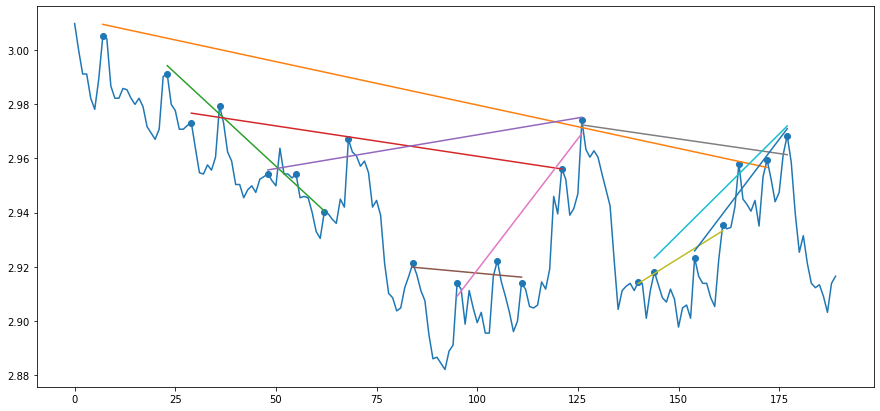

In [466]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(df)), df.log_adj_close)
for i in range(len(final_df)):

    plt.plot([final_df.first_point[i], final_df.last_point[i]], [final_df.coefs[i] * final_df.first_point[i]+final_df.intercepts[i], final_df.coefs[i] * final_df.last_point[i]+final_df.intercepts[i]])
plt.scatter(opt, opt_price)

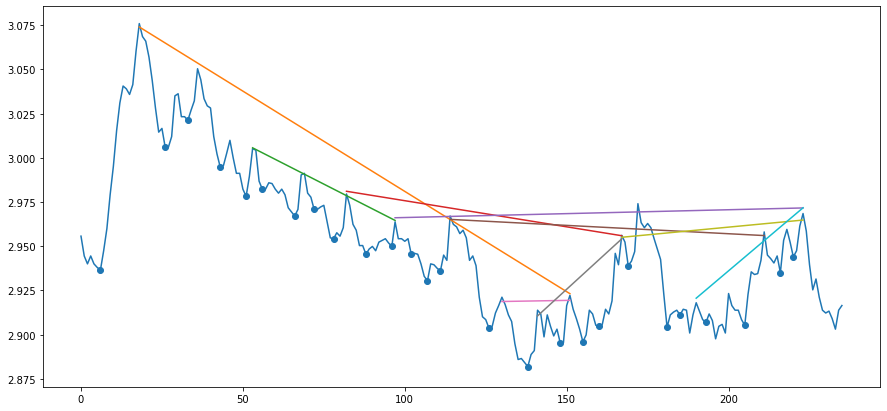

In [388]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(df)), df.log_adj_close)
for i in range(len(start)):
    plt.plot([start[i], stop[i]], [a[i] * start[i]+b[i], a[i] * stop[i]+b[i]])
plt.scatter(lows, df.log_adj_close[lows])


In [381]:
len(lows)

16

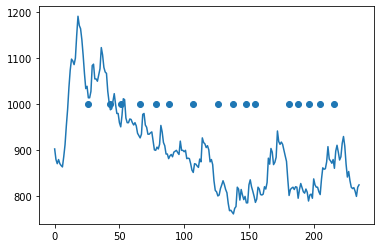

In [347]:
plt.plot(np.arange(len(df.close)), df.close)
plt.scatter(lows, [1000 for i in range(len(lows))])

In [339]:
len(start)

8

In [151]:
lows = []
lows_price = []
last = -10000
for j in range(len(df.log_adj_close)): 
#         minimum = min(stocko[j], stockc[j])
    if ( (j >10) and (j+10 < len(df.log_adj_close)) ):
        if (df.log_adj_close[j]<= min(df.log_adj_close[j-10:j+10]) and last < j - 10):
            last = j
#             if (minimum<= min(stocko[j-10:j+10]) and minimum<= min(stockc[j-10:j+10])):
            lows.append(j)
            lows_price.append(df.log_adj_close[j])

In [146]:
part

[26, 27, 51, 66, 88, 107, 138, 196]

In [ ]:
parting
part

In [109]:
dff["mse/touch"] = dff.mse/dff.touch

In [117]:
lines_df = pd.DataFrame([[1, 2, 3], [4, 5, 7]], columns = ["a", "b", "start"])

In [134]:
pp = lines_df[lines_df.start == max([lines_df.start])].iloc[0]

NameError: name 'bestline' is not defined

In [153]:
%%time
start, stop, a, b, dff = find_supports(df)

[12553     0     0     0     0     0     0     0     0     0]
CPU times: user 39.2 s, sys: 0 ns, total: 39.2 s
Wall time: 39.2 s


In [80]:
dff.head()

,a,b,start,stop,mse,touch
0,-0.000873,3.030865,19.0,174.0,0.000014,4.0
1,-0.000871,3.030832,19.0,174.0,0.000015,4.0
2,-0.000869,3.030799,19.0,174.0,0.000015,4.0
3,-0.000867,3.030765,19.0,174.0,0.000016,4.0
4,-0.000866,3.030732,19.0,174.0,0.000016,4.0


In [71]:
lines_df.head()

,a,b,start,stop,mse,touch


In [156]:
dff

,a,b,start,stop,mse,touch,mse/touch


In [104]:
from data_provider import DataModel
dm = DataModel()
dm.read_from_csvs("../../xcels", ["master0.csv", "master1.csv"])
df = dm.get(dm.TA_SYMBOLS[0], "1396-01-01", "1397-01-01")

2020-01-23 14:05:31.910 | DEBUG    | data_provider:get:172 - symbol is not scaled: خپارس
2020-01-23 14:05:32.114 | DEBUG    | data_provider:adjust_and_log:57 - start adjust and log for خپارس
2020-01-23 14:05:32.116 | DEBUG    | data_provider:adjust_and_log:58 - calculating scale
2020-01-23 14:05:32.429 | DEBUG    | data_provider:adjust_and_log:60 - adding adjust
2020-01-23 14:05:32.432 | DEBUG    | data_provider:add_adjust:28 - new part len is 3459, shape: (3459,)
2020-01-23 14:05:32.468 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2009-06-08 00:00:00
2020-01-23 14:05:32.481 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2010-07-05 00:00:00
2020-01-23 14:05:32.493 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2011-07-05 00:00:00
2020-01-23 14:05:32.514 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2012-06-23 00:00:00
2020-01-23 14:05:32.543 | DEBUG    | data_provider:add_adjust:38 - found adj date: 2014-05-26 00:00:00
2020-01-23 14:05

In [3]:
dm.TA_SYMBOLS[0]

'خپارس'

In [33]:
df.log_adj_close[lows]

date
2016-04-20    3.027513
2016-05-17    2.995240
2016-06-20    2.972203
2016-08-01    2.958707
2016-09-05    2.937117
2016-11-12    2.950267
2017-01-09    2.914343
2017-02-13    2.935003
Name: log_adj_close, dtype: float64

In [19]:
a_in_radian = math.atan(8.735e-7)
a_in_degree = math.degrees(a_in_radian)
a_in_degree

5.004786340466468e-05

In [41]:
math.log10(100)

2.0

In [23]:
a

[-0.0008726648475212713,
 -0.0008639294592936493,
 -0.0004883078725776307,
 -0.0002804057580449762,
 0.0007468752692325392]